In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.utils import shuffle
from __future__ import print_function
from io import StringIO
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [21]:
df = pd.read_csv('stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
df = df.sample(frac=0.5, random_state=99).reset_index(drop=True)
df = shuffle(df, random_state=22)
df = df.reset_index(drop=True)
df['class_label'] = df['tags'].factorize()[0]
class_label_df = df[['tags', 'class_label']].drop_duplicates().sort_values('class_label')
label_to_id = dict(class_label_df.values)
id_to_label = dict(class_label_df[['class_label', 'tags']].values)

In [22]:
df.head(10)

post           tags  \
0  how do i move something in rails   i m a progr...  ruby-on-rails   
1  c#   how to output specific array searches   t...             c#   
2  integer.parseint and string format with decima...           java   
3  compilation problem while upgrading a website ...           .net   
4  query to list out the records by comparing max...            sql   
5  why don t @interface  @imp... and @end require...    objective-c   
6  creating form for multiple models  i need some...  ruby-on-rails   
7  can t figure out why my angular view is blank ...      angularjs   
8  error “ name database does not exist in curren...        asp.net   
9  overplot data with multiple x-axis in python  ...         python   

   class_label  
0            0  
1            1  
2            2  
3            3  
4            4  
5            5  
6            0  
7            6  
8            7  
9            8

In [23]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)

In [24]:
df.head()

post           tags  \
0  move something rails programming noob learning...  ruby-on-rails   
1  c# output specific array searches program crea...             c#   
2  integerparseint string format decimal number t...           java   
3  compilation problem upgrading website visualst...           .net   
4  query list records comparing maximum number re...            sql   

   class_label  
0            0  
1            1  
2            2  
3            3  
4            4

In [6]:
list_corpus = df["post"].tolist()
list_labels = df["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [7]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [8]:
pred = logreg.predict(test_vectors)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.798, precision = 0.801, recall = 0.798, f1 = 0.799


In [9]:
c = make_pipeline(vectorizer, logreg)
class_names=list(df.tags.unique())
explainer = LimeTextExplainer(class_names=class_names)

In [10]:
class_names

['ruby-on-rails',
 'c#',
 'java',
 '.net',
 'sql',
 'objective-c',
 'angularjs',
 'asp.net',
 'python',
 'javascript',
 'iphone',
 'c',
 'android',
 'css',
 'php',
 'html',
 'jquery',
 'mysql',
 'ios',
 'c++']

In [11]:
idx = 1877
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, labels=[4, 8])
print('Document id: %d' % idx)
print('Predicted class =', class_names[logreg.predict(test_vectors[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[y_test[idx]])

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Document id: 1877
Predicted class = sql
True class: sql


In [12]:
print ('Explanation for class %s' % class_names[4])
print ('\n'.join(map(str, exp.as_list(label=4))))

Explanation for class sql
('sql', 0.6326626857717909)
('date', 0.11562405901266143)
('query', 0.08730712530365084)
('values', 0.052699789384404436)
('execute', -0.04424623466659338)
('s', -0.04103939933741401)


In [13]:
print ('Explanation for class %s' % class_names[8])
print ('\n'.join(map(str, exp.as_list(label=8))))

Explanation for class python
('sql', -0.14435732364139484)
('query', -0.07761100453729707)
('range', 0.07204575624937577)
('1', 0.032041933794168365)
('date', -0.021905004284891793)
('d', 0.021236716325567367)


In [19]:
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


[4, 8]


In [33]:
exp.show_in_notebook(text=False)

In [34]:
exp.show_in_notebook(text=y_test[idx], labels=(4,))

In [35]:
exp.show_in_notebook(text=y_test[idx], labels=(8,))

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import shap

In [25]:
tags_split = [tags.split(',') for tags in df['tags'].values]
print(tags_split[:10])

[['ruby-on-rails'], ['c#'], ['java'], ['.net'], ['sql'], ['objective-c'], ['ruby-on-rails'], ['angularjs'], ['asp.net'], ['python']]


In [26]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(df['post'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

move something rails programming noob learning rails making gtd webapp fun like make done section words link says done want move current task done page instead indexhtmlerb know rails official beginner tutorial
['.net' 'android' 'angularjs' 'asp.net' 'c' 'c#' 'c++' 'css' 'html' 'ios'
 'iphone' 'java' 'javascript' 'jquery' 'mysql' 'objective-c' 'php' 'python'
 'ruby-on-rails' 'sql']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [27]:
train_size = int(len(df) * .8)
print('train size: %d' % train_size)
print('test size: %d' % (len(df) - train_size))

train size: 16000
test size: 4000


In [28]:
y_train = tags_encoded[: train_size]
y_test = tags_encoded[train_size:]

In [29]:
class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

In [44]:
VOCAB_SIZE = 500
train_post = df['post'].values[: train_size]
test_post = df['post'].values[train_size: ]
processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_post)
X_train = processor.transform_text(train_post)
X_test = processor.transform_text(test_post)

In [45]:
print(len(X_train[0]))
print(X_train[0])

500
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [46]:
def create_model(vocab_size, num_tags):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, input_shape = (VOCAB_SIZE,), activation='relu'))
    model.add(tf.keras.layers.Dense(25, activation='relu'))
    model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_7 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                520       
Total params: 26,845
Trainable params: 26,845
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(X_train, y_train, epochs = 2, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(model.evaluate(X_test, y_test, batch_size = 128)))

Train on 14400 samples, validate on 1600 samples
Epoch 1/2
14400/14400 [==============================] - ETA: 1:32 - loss: 0.6861 - acc: 0.565 - ETA: 6s - loss: 0.6382 - acc: 0.6985  - ETA: 2s - loss: 0.5634 - acc: 0.795 - ETA: 1s - loss: 0.4969 - acc: 0.842 - ETA: 0s - loss: 0.4303 - acc: 0.873 - ETA: 0s - loss: 0.3985 - acc: 0.886 - ETA: 0s - loss: 0.3736 - acc: 0.895 - ETA: 0s - loss: 0.3527 - acc: 0.903 - ETA: 0s - loss: 0.3322 - acc: 0.909 - 1s 94us/step - loss: 0.3317 - acc: 0.9099 - val_loss: 0.2057 - val_acc: 0.9500
Epoch 2/2
4000/4000 [==============================] - ETA:  - ETA:  - 0s 23us/step
Eval loss/accuracy:[0.14230631446838379, 0.95524988889694218]


In [48]:
attrib_data = X_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 20
shap_vals = explainer.shap_values(X_test[:num_explanations])

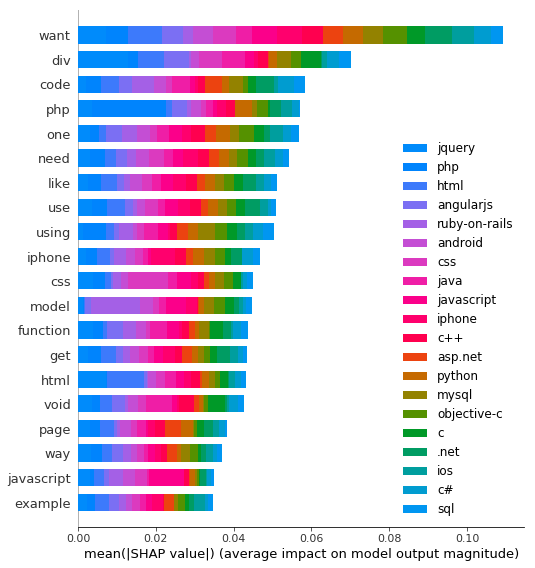

In [49]:
words = processor._tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)